In [7]:
import torch
import os


from script.plot_and_print import plot_data_mapped, print_metrics, plot_data_scatter
from script.process_csv import generate_results, merge_data, process_spatial_data, ann_data_to_csv
from script.model import get_res18_ciga, get_res50, get_res50_dropout
import pandas as pd
import scipy

In [19]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
batch_size = 64
data_dir = "../Training_Data/"
data_dir_test = "../Test_Data/"

criterion = torch.nn.CrossEntropyLoss()
patients = [os.path.basename(f) for f in os.scandir(data_dir) if f.is_dir()]
patients_test = [os.path.basename(f) for f in os.scandir(data_dir_test) if f.is_dir()][1:]
print(patients_test)
gene = "RUBCNL"

['p026', 'p008']


In [9]:
for patient in patients:
    ann_data_to_csv(data_dir)
    process_spatial_data(patients, data_dir)
    merge_data(data_dir, patient)

../../Training_Data/p020/Preprocessed_STDataset/merge.csv
../../Training_Data/p016/Preprocessed_STDataset/merge.csv
../../Training_Data/p014/Preprocessed_STDataset/merge.csv
../../Training_Data/p013/Preprocessed_STDataset/merge.csv
../../Training_Data/p025/Preprocessed_STDataset/merge.csv
../../Training_Data/p007/Preprocessed_STDataset/merge.csv
../../Training_Data/p009/Preprocessed_STDataset/merge.csv


In [10]:
def process_and_plot_patient(model, device, criterion, data_dir, patient, gene = "RUBCNL", results_filename = "results.csv"):
    generate_results(model, device, criterion, data_dir, patient, gene, results_filename)
    merge_data(data_dir, patient, results_filename)
    plot_data_mapped(data_dir, patient, "labels")
    plot_data_mapped(data_dir, patient, "output")
    plot_data_mapped(data_dir, patient, "diff")
    plot_data_scatter(data_dir, patient, gene)
    print_metrics(data_dir, patient, "mean")
    print_metrics(data_dir, patient, "std")
    print_metrics(data_dir, patient, "pearson")
    
    print("----------------------------------------")
    
def process_patients(model, device, criterion, data_dir, patients, gene = "RUBCNL", results_filename = "results.csv"):
    results = []
    for patient in patients:
        generate_results(model, device, criterion, data_dir, patient, gene, results_filename)
        merge_data(data_dir, patient, results_filename)
        base_path = data_dir + patient + "/Preprocessed_STDataset/"
        merge = pd.read_csv(base_path + "merge.csv")
        out = merge['output']
        labels = merge['labels']
        mean_out = out.mean()
        std_out = out.std()
        mean_labels = labels.mean()
        std_labels = labels.std()
        pearson = round(scipy.stats.pearsonr(out, labels)[0], 2)
        results.append((mean_out, std_out, mean_labels, std_labels, pearson, patient))
    return results

In [11]:
path = "../models/res18/res18_not_iced_e29.pt"
res18_no_ice = get_res18_ciga(path).to(device)
path = "../models/res18/res18_iced_e29.pt"
res18_ice    = get_res18_ciga(path).to(device)
path = "../models/res50/RUBCNL_HLR_Res50_Drop/24072024_ep_29_lr_0.0005resnet.pt"
res50_drop    = get_res50_dropout(path).to(device)

<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>


In [20]:
raw = []
raw.append(("../models/res50/RUBCNL_HLR_Res50slim/15072024_ep_39_lr_0.0005resnet.pt", get_res50))
raw.append(("../models/res50/RUBCNL_HLR_Res50slim_ice/15072024_ep_39_lr_0.0005resnet.pt", get_res50))
raw.append(("../models/res50/RUBCNL_HLR_Res50slim_optim_ice/RUBCNL_HLR_Res50slim_optim_ice15072024_ep_26_lr_0.0005resnet.pt", get_res50))
raw.append(("../models/res50/RUBCNL_HLR_Res50_Drop/24072024_ep_29_lr_0.0005resnet.pt", get_res50_dropout))
raw.append(("../models/res18/res18_iced_e29.pt",get_res18_ciga))
raw.append(("../models/res18/res18_not_iced_e29.pt", get_res18_ciga))

models = []
for r in raw:
    models.append((r[1](r[0]).to(device).eval(), r[0]))
    
for model in models:
    print(type(model))
lines = []
for model,path in models:
    results = process_patients(model.to(device), device, criterion, data_dir_test, patients_test, gene, results_filename = "slim_model_results.csv")
    line = [path, str(type(model)), gene, ]

    for i in results:
        for j in i:
            line.append(str(j))
    lines.append(line)
    # mean_out, std_out, mean_labels, std_labels, pearson, patient

<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
generating results...
0 / 5249
1000 / 5249
2000 / 5249
3000 / 5249
4000 / 5249
5000 / 5249
../../Test_Data/p026/Preprocessed_STDataset/merge.csv
generating results...
0 / 3649
1000 / 3649
2000 / 3649
3000 / 3649
generating results...
0 / 5249
1000 / 5249
2000 / 5249
3000 / 5249
4000 / 5249
5000 / 5249
../../Test_Data/p026/Preprocessed_STDataset/merge.csv
generating results...
0 / 3649
1000 / 3649
2000 / 3649
3000 / 3649
generating results...
0 / 5249
1000 / 5249
2000 / 5249
3000 / 5249
4000 / 5249
5000 / 5249
../../Test_Data/p026/Preprocessed_STDataset/merge.csv
generating results...
0 / 3649
1000 / 3649
2000 / 3649
3000 / 3649
generating results...
0 / 5249
1000 / 5249
2000 / 5249
3000 / 5249
4000 / 52

In [22]:
columns = ["model_name", "model_type", "gene"]
to_append = [[s + "_mean_out", s + "_std_out", s + "_mean_labels", s + "_std_labels", s + "_pearson", s] for s in patients_test]
for s in to_append:
    for t in s:
        columns.append(t)
print(len(columns))
# mean_out, std_out, mean_labels, std_labels, pearson, patient
print(patients_test)

15
['p026', 'p008']


In [24]:
print(len(lines[0]))
df = pd.DataFrame(lines, columns=columns)
df.drop(patients_test, axis=1, inplace=True)
df.head()


15


,model_name,model_type,gene,p026_mean_out,p026_std_out,p026_mean_labels,p026_std_labels,p026_pearson,p008_mean_out,p008_std_out,p008_mean_labels,p008_std_labels,p008_pearson
0,../../models/res50/RUBCNL_HLR_Res50slim/150720...,<class 'model.MyNet2'>,RUBCNL,-0.06383429842534291,0.7589094025294596,0.00042798394886644803,1.0008722168183515,0.62,-0.21239644837027405,0.2612790590241495,-0.0007326909454645342,0.9997073911889839,0.31
1,../../models/res50/RUBCNL_HLR_Res50slim_ice/15...,<class 'model.MyNet2'>,RUBCNL,-0.11675645821762619,0.553610944858721,0.00042798394886644803,1.0008722168183515,0.58,-0.21239644837027405,0.2612790590241495,-0.0007326909454645342,0.9997073911889839,0.31
2,../../models/res50/RUBCNL_HLR_Res50slim_optim_...,<class 'model.MyNet2'>,RUBCNL,-0.09102414679315679,0.5675467919700053,0.00042798394886644803,1.0008722168183515,0.58,-0.21239644837027405,0.2612790590241495,-0.0007326909454645342,0.9997073911889839,0.31
3,../../models/res50/RUBCNL_HLR_Res50_Drop/24072...,<class 'model.Res50Dropout'>,RUBCNL,-0.08848778598162507,0.3723818085353338,0.00042798394886644803,1.0008722168183515,0.58,-0.21239644837027405,0.2612790590241495,-0.0007326909454645342,0.9997073911889839,0.31
4,../../models/res18/res18_iced_e29.pt,<class 'model.Res18'>,RUBCNL,-0.08798186230701086,0.6832121161069108,0.00042798394886644803,1.0008722168183515,0.62,-0.21239644837027405,0.2612790590241495,-0.0007326909454645342,0.9997073911889839,0.31


In [25]:
df.to_csv("results_all_models_test.csv")

generating results...
0 / 5249
1000 / 5249
2000 / 5249
3000 / 5249
4000 / 5249
5000 / 5249
../../Test_Data/p026/Preprocessed_STDataset/merge.csv


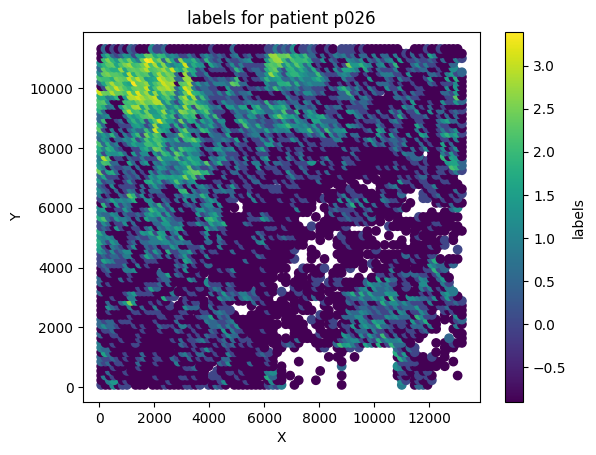

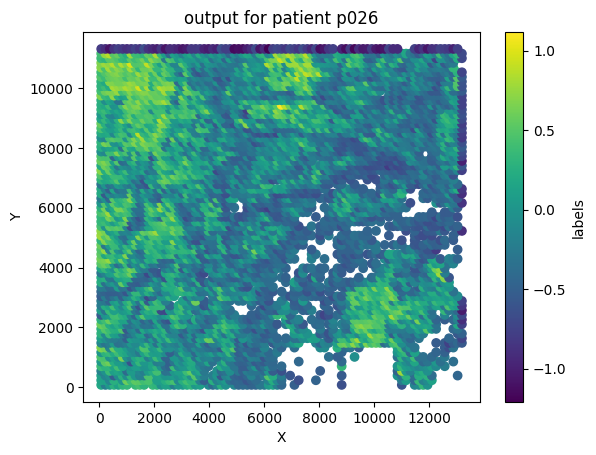

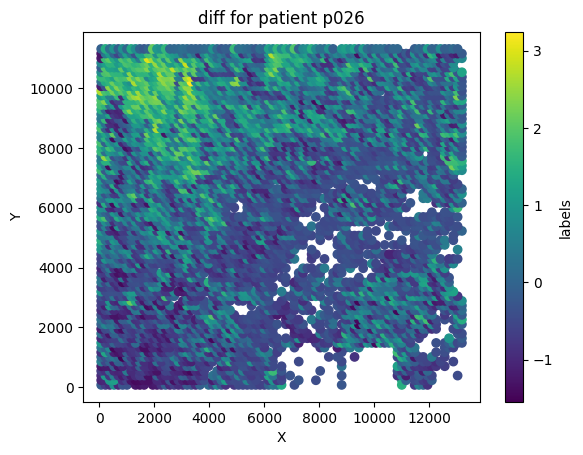

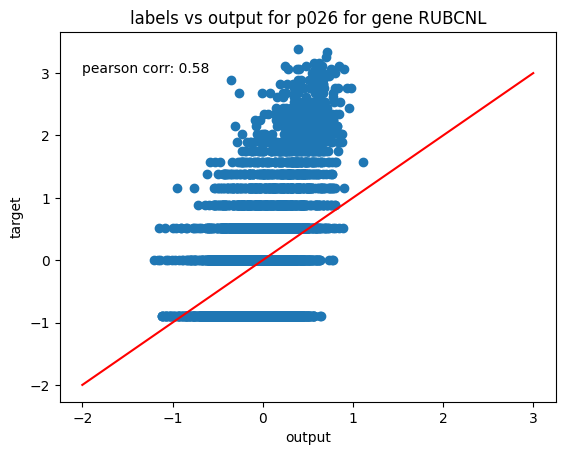

mean diff:  0.0889 , mean out:  -0.0885 , mean labels:  0.0004
std diff:  0.6285 , std out:  0.3724 , std labels:  1.0009
----------------------------------------


In [26]:
data_dir = "../Training_Data/"

patients = [os.path.basename(f) for f in os.scandir(data_dir) if f.is_dir()]
patient = "p026"
process_and_plot_patient(res50_drop.to(device), device, criterion, data_dir_test, patient, "RUBCNL", results_filename = "slim_model_results.csv")
    